In [1]:
#import
import pandas as pd
import numpy as np
import hddm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pymc
import kabuki
sns.set(style="white")
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

/home/krishn/anaconda3/envs/hddm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/krishn/anaconda3/envs/hddm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/krishn/anaconda3/envs/hddm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/krishn/anaconda3/envs/hddm/lib/python3.6/site-

tanh
tanh
tanh
linear


/home/krishn/anaconda3/envs/hddm/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [ ]:
# #load data. you will find this dataset in your hddm-folder under hddm/examples/rlddm_data.csv
# data = hddm.load_csv('rlddm_data.csv')
# if np.any(data["response"] != 1.0):
#     idx = data["response"] < 1.0
#     data.loc[idx, "response"] = -1.0
# #check structure
# data = data.loc[data['subj_idx'] == 42, :] #head()
# data.head()

In [2]:
data = hddm.generate.gen_rand_rlddm_data(a=1,t=0.3,alpha=0.2,scaler=2,p_upper=0.8,p_lower=0.2,subjs=1,split_by=0,size=500)
if np.any(data["response"] != 1.0):
    idx = data["response"] < 1.0
    data.loc[idx, "response"] = -1.0

data['q_init'] = 0.5
# data.insert(-1, "q_init", [0.5]*500)
data.head()

,q_up,q_low,sim_drift,response,rt,feedback,subj_idx,split_by,trial,q_init
0,0.5000,0.5,0.0000,1.0,0.640,1.0,0,0,1,0.5
1,0.6000,0.5,0.2000,1.0,0.380,1.0,0,0,2,0.5
2,0.6800,0.5,0.3600,1.0,0.732,1.0,0,0,3,0.5
3,0.7440,0.5,0.4880,1.0,0.741,1.0,0,0,4,0.5
4,0.7952,0.5,0.5904,-1.0,0.339,0.0,0,0,5,0.5


In [ ]:
print(data["response"])

The columns in the datafile represent: __subj_idx__ (subject id), __response__ (1=best option), __cond__ (identifies condition, but not used in model), __rt__ (in seconds), 0=worst option), __trial__ (the trial-iteration for a subject within each condition), __split_by__ (identifying condition, used for running the model), __feedback__ (whether the response given was rewarded or not), __q_init__ (the initial q-value used for the model, explained above).

In [3]:
#run the model by calling hddm.HDDMrl (instead of hddm.HDDM for normal HDDM)
m = hddm.HDDMrl(data)

#set sample and burn-in
m.sample(1000,burn=100,dbname='traces.db',db='pickle')
#print stats to get an overview of posterior distribution of estimated parameters
m.print_stats()

{}
()
No model attribute --> setting up standard HDDM
Includes supplied:  ()
printing self.nn
False
Set model to ddm
 [-----------------100%-----------------] 1000 of 1000 complete in 27.4 sec           mean         std      2.5q       25q       50q       75q     97.5q       mc err
a      0.485028   0.0129766  0.459304  0.476311  0.484257  0.493576  0.509636  0.000640874
v       2.15114    0.149206   1.86679   2.04738   2.15018   2.25482   2.44715   0.00573224
t        0.2978  0.00340626  0.290326  0.295699   0.29804  0.300139  0.303888  0.000156529
alpha  -1.27873     0.53843  -2.30111  -1.63487  -1.26977 -0.931282 -0.272965    0.0207561
DIC: -207.557984
deviance: -211.540589
pD: 3.982604


__Interpreting output from print_stats:__  <br>
The model estimates group mean and standard deviation parameters and subject parameters for the following latent variables: <br>
a = decision threshold <br>
v = scaling parameter <br>
t = non-decision time <br>
alpha = learning rate, note that it's not bound between 0 and 1. to transform take inverse logit: np.exp(alpha)/(1+np.exp(alpha)) <br>
The columns represent the mean, standard deviation and quantiles of the approximated posterior distribution of each parameter

### HDDMrl vs. HDDM
__There are a few things to note that is different from the normal HDDM model.__ <br>
First of all, the estimated learning rate does not necessarily fall between 0 and 1. This is because it is estimated as a normal distribution for purposes of sampling hierarchically and then transformed by an inverse logit function to 0<alpha<1. So to interpret alpha as learning rate you have to transform the samples in the trace back with np.exp(alpha)/(1+np.exp(alpha)). And if you estimate separate learning rates for positive and negative prediction errors ([see here](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)) then you get learning rate for negative prediction errors with np.exp(alpha)/(1+np.exp(alpha)) and positive prediction errors with np.exp(pos_alpha)/(1+np.exp(pos_alpha)).<br>
Second, the v-parameter in the output is the scaling factor that is multiplied by the difference in q-values, so it is not the actual drift rate (or rather, it is the equivalent drift rate when the difference in Q values is exactly 1).

## 6. Checking results

Plotting a
Plotting v
Plotting t
Plotting alpha


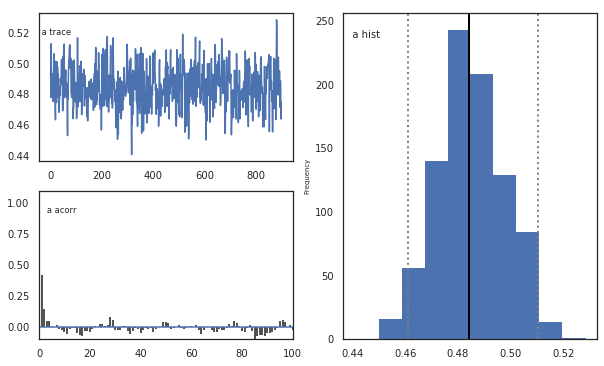

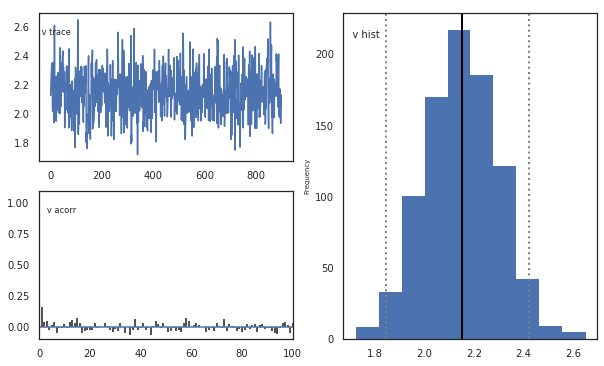

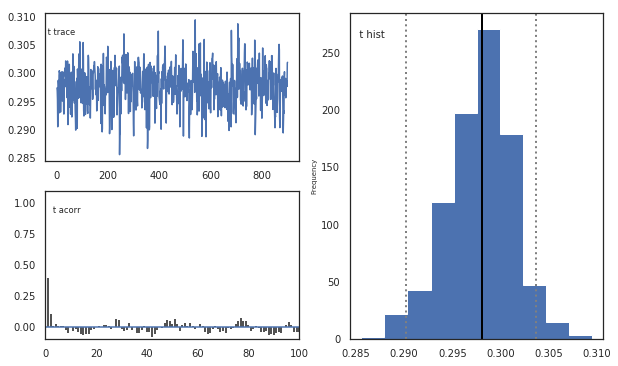

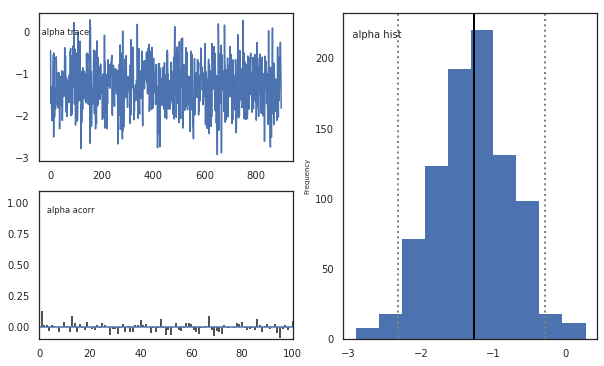

In [4]:
# plot the posteriors of parameters 
m.plot_posteriors()

In [ ]:
import hddm.simulators
out_vanilla = hddm.simulators.simulator(theta = [1, 2, 0.5, 1], model = 'ddm_vanilla', n_samples = 5000)
out_ddm = hddm.simulators.simulator(theta = [1, 1.0, 0.5, 1], model='ddm', n_samples = 5000)

In [ ]:
np.mean(out_vanilla[0][out_vanilla[1] == 1])

In [ ]:
out_vanilla[1][out_vanilla[1] == 1].shape

In [ ]:
np.mean(out_ddm[0][out_ddm[1] == 1])

In [ ]:
out_ddm[1][out_ddm[1] == 1].shape

### Convergence of chains
The Gelman-Rubin statistic is a test of whether the chains in the model converges. The Gelman-Ruben statistic measures the degree of variation between and within chains. Values close to 1 indicate convergence and that there is small variation between chains, i.e. that they end up as the same distribution across chains. A common heuristic is to assume convergence if all values are below 1.1. To run this you need to run multiple models, combine them and perform the Gelman-Rubin statistic:

In [ ]:
# estimate convergence
from kabuki.analyze import gelman_rubin

models = []
for i in range(3):
    m = hddm.HDDMrl(data=data)
    m.sample(1500, burn=500,dbname='traces.db',db='pickle')
    models.append(m)

gelman_rubin(models)

In [ ]:
np.max(list(gelman_rubin(models).values()))

The model seems to have converged, i.e. the Gelman-Rubin statistic is below 1.1 for all parameters. It is important to always run this test, especially for more complex models ([as with separate learning rates for positive and negative prediction errors](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)). So now we can combine these three models to get a better approximation of the posterior distribution.

In [ ]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)

### Joint posterior distribution
Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what's usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. [Daw, 2011](https://www.oxfordscholarship.com/view/10.1093/acprof:oso/9780199600434.001.0001/acprof-9780199600434-chapter-001)).

In [ ]:
alpha, t, a, v = m.nodes_db.node[['alpha', 't', 'a','v']]
samples = {'alpha':alpha.trace(),'t':t.trace(),'a':a.trace(),'v':v.trace()}
samp = pd.DataFrame(data=samples)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')

## 7. Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

### extract traces
The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).

In [ ]:
traces = m.get_traces()
traces.head()

### simulating data
__Now that we have the traces the next step is to simulate data using the estimated parameters. The RLDDM includes a function to simulate data. Here's an example of how to use the simulation-function for RLDDM. This example explains how to generate data with binary outcomes. See [here](#11.-Probabilistic-binary-outcomes-vs.-normally-distributed-outcomes) for an example on simulating data with normally distributed outcomes. Inputs to function: <br>
a__ = decision threshold <br>
**t** = non-decision time <br>
__alpha__ = learning rate <br>
__pos_alpha__ = defaults to 0. if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate_ for negative prediction errors.  <br>
__scaler__ = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate <br>
__p_upper__ = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0 <br>
__p_lower__ = the probability of reward for the option represented by the lower boundary. <br>
__subjs__ = number of subjects to simulate data for. <br>
__split_by__ = define the condition which makes it easier to append data from different conditions. <br>
__size__ = number of trials per subject. <br>

In [ ]:
hddm.generate.gen_rand_rlddm_data(a=1,t=0.3,alpha=0.2,scaler=2,p_upper=0.8,p_lower=0.2,subjs=1,split_by=0,size=10)

__How to interpret columns in the resulting dataframe__ <br>
__q_up__ = expected reward for option represented by upper boundary <br>
__q_low__ = expected reward for option represented by lower boundary <br>
__sim_drift__ = the drift rate for each trial calculated as: (q_up-q_low)*scaler <br>
__response__ = simulated choice <br>
__rt__ = simulated response time <br>
__feedback__ = observed feedback for chosen option <br>
__subj_idx__ = subject id (starts at 0) <br>
__split_by__ = condition as integer <br>
__trial__ = current trial (starts at 1) <br>

### Simulate data with estimated parameter values and compare to observed data
Now that we know how to extract traces and simulate data we can combine this to create a dataset similar to our observed data. This process is currently not automated but the following is an example code using the dataset we analyzed above.

In [ ]:
from tqdm import tqdm #progress tracker
#create empty dataframe to store simulated data
sim_data = pd.DataFrame()
#create a column samp to be used to identify the simulated data sets
data['samp'] = 0
#load traces
traces = m.get_traces()
#decide how many times to repeat simulation process. repeating this multiple times is generally recommended, 
#as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1,51)):
    #randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0,traces.shape[0]-1)
    #loop through all subjects in observed data
    for s in data.subj_idx.unique():
        #get number of trials for each condition.
        size0 = len(data[(data['subj_idx']==s) & (data['split_by']==0)].trial.unique())
        size1 = len(data[(data['subj_idx']==s) & (data['split_by']==1)].trial.unique())
        size2 = len(data[(data['subj_idx']==s) & (data['split_by']==2)].trial.unique())
        #set parameter values for simulation
        a = traces.loc[sample,'a_subj.'+str(s)]
        t = traces.loc[sample,'t_subj.'+str(s)]
        scaler = traces.loc[sample,'v_subj.'+str(s)]
        alphaInv = traces.loc[sample,'alpha_subj.'+str(s)]
        #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size0,p_upper=0.8,p_lower=0.2,split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size1,p_upper=0.7,p_lower=0.3,split_by=1)
        sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        #append the conditions
        sim_data0 = sim_data0.append([sim_data1,sim_data2],ignore_index=True)
        #assign subj_idx
        sim_data0['subj_idx'] = s
        #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        #identify the simulated data
        sim_data0['samp'] = i
        #append data from each subject
        sim_data = sim_data.append(sim_data0,ignore_index=True)
#combine observed and simulated data
ppc_data = data[['subj_idx','response','split_by','rt','trial','feedback','samp']].copy()
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx','response','split_by','rt','trial','feedback','type','samp']].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv('ppc_data_tutorial.csv')

### Plotting
Now that we have a dataframe with both observed and simulated data we can plot to see whether the simulated data are able to capture observed choice and reaction times. To capture the uncertainty in the simulated data we want to identify how much choice and reaction differs across the simulated data sets. A good measure of this is to calculate the highest posterior density/highest density interval for summary scores of the generated data. Below we calculate highest posterior density with an alpha set to 0.1, which means that we are describing the range of the 90% most likely values.

In [ ]:
#for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial<41].copy()

### Choice

In [ ]:
#bin trials to for smoother estimate of response proportion across learning
plot_ppc_data['bin_trial'] = pd.cut(plot_ppc_data.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
#calculate means for each sample
sums = plot_ppc_data.groupby(['bin_trial','split_by','samp','type']).mean().reset_index()
#calculate the overall mean response across samples
ppc_sim = sums.groupby(['bin_trial','split_by','type']).mean().reset_index()
#initiate columns that will have the upper and lower bound of the hpd
ppc_sim['upper_hpd'] = 0
ppc_sim['lower_hpd'] = 0
for i in range(0,ppc_sim.shape[0]):
    #calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial']==ppc_sim.bin_trial[i]) & (sums['split_by']==ppc_sim.split_by[i]) & (sums['type']==ppc_sim.type[i])],alpha=0.1)
    ppc_sim.loc[i,'upper_hpd'] = hdi[1]
    ppc_sim.loc[i,'lower_hpd'] = hdi[0]
#calculate error term as the distance from upper bound to mean
ppc_sim['up_err'] = ppc_sim['upper_hpd']-ppc_sim['response']
ppc_sim['low_err'] = ppc_sim['response']-ppc_sim['lower_hpd']
ppc_sim['model'] = 'RLDDM_single_learning'
ppc_sim.to_csv('ppc_choicedata_tutorial.csv')

In [ ]:
#plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5),nrows=1, ncols=3, sharex=True,sharey=True)
for i in range(0,3):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by==i) & (ppc_sim.type=='simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[d.low_err,d.up_err], label='simulated',color='orange')
    d = ppc_sim[(ppc_sim.split_by==i) & (ppc_sim.type=='observed')]
    ax.plot(d.bin_trial, d.response,linewidth=3,label='observed')
    ax.set_title('split_by = %i' %i,fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()
fig.savefig('PPCchoice.pdf')

__Fig.__ The plots display the rate of choosing the best option (response = 1) across learning and condition. The model generates data (orange) that closely follows the observed behavior (blue), with the exception of overpredicting performance early in the most difficult condition (split_by=2). Uncertainty in the generated data is captured by the 90% highest density interval of the means across simulated datasets.

### RT

In [ ]:
#set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data['reaction time'] = np.where(plot_ppc_data['response']==1,plot_ppc_data.rt,0-plot_ppc_data.rt)
#plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy. 
g = sns.FacetGrid(plot_ppc_data,col='split_by',hue='type')
g.map(sns.kdeplot, 'reaction time',bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig('PPCrt_dist.pdf')

__Fig.__ Density plots of observed and predicted reaction time across conditions. RTs for lower boundary choices (i.e. worst option choices) are set to be negative (0-RT) to be able to separate upper and lower bound responses.

## 8. Parameter recovery
To validate the RLDDM we ran a parameter recovery study to test to which degree the model can recover the parameter values used to simulate data. To do this we generated 81 synthetic datasets with 50 subjects performing 70 trials each. The 81 datasets were simulated using all combinations of three plausible parameter values for decision threshold, non-decision time, learning rate and the scaling parameter onto drift rate.

### Estimated values split by simulated vales 
We can plot simulated together with the estimated values to test the models ability to recover parameters, and to see if there are any values that are more difficult to recover than others.

In [ ]:
param_recovery = hddm.load_csv('recovery_sim_est_rlddm.csv')

In [ ]:
g = sns.catplot(x='a',y='e_a',data=param_recovery,palette='Set1')
g.set_axis_labels("Simulated threshold", "Estimated threshold")
plt.title("Decision threshold")
g.savefig('Threshold_recovery.pdf')

In [ ]:
g = sns.catplot(x='alpha',y='e_alphaT',data=param_recovery,palette='Set1')
g.set_axis_labels("Simulated alpha", "Estimated alpha")
plt.title("Learning rate")
g.savefig('Alpha_recovery.pdf')

In [ ]:
g = sns.catplot(x='scaler',y='e_v',data=param_recovery,palette='Set1')
g.set_axis_labels("Simulated scaling", "Estimated scaling")
plt.title("Scaling drift rate")
g.savefig('Scaler_recovery.pdf')

In [ ]:
g = sns.catplot(x='t',y='e_t',data=param_recovery,palette='Set1')
g.set_axis_labels("Simulated NDT", "Estimated NDT")
plt.title("Non-decision time")
g.savefig('NDT_recovery.pdf')

__Fig.__ The correlation between simulated and estimated parameter values are high, which means recovery is good. There is somewhat worse recovery for the learning rate and scaling parameter, which makes sense given that they to a degree can explain the same variance (see below).

## 9. Separate learning rates for positive and negative prediction errors
Several studies have reported differences in updating of expected rewards following positive and negative prediction errors (e.g. to capture differences between D1 and D2 receptor function). To model asymmetric updating rates for positive and negative prediction errors you can set dual=True in the model. This will produce two estimated learning rates; alpha and pos_alpha, of which alpha then becomes the estimated learning rate for negative prediction errors.

In [ ]:
#set dual=True to model separate learning rates for positive and negative prediction errors.
m_dual = hddm.HDDMrl(data,dual=True)
#set sample and burn-in
m_dual.sample(1500,burn=500,dbname='traces.db',db='pickle')
#print stats to get an overview of posterior distribution of estimated parameters
m_dual.print_stats()

In [ ]:
m_dual.plot_posteriors()

__Fig.__ There's more autocorrelation in this model compared to the one with a single learning rate. First, let's test whether it converges.

In [ ]:
# estimate convergence
models = []
for i in range(3):
    m = hddm.HDDMrl(data=data,dual=True)
    m.sample(1500, burn=500,dbname='traces.db',db='pickle')
    models.append(m)

#get max gelman-statistic value. shouldn't be higher than 1.1
np.max(list(gelman_rubin(models).values()))

In [ ]:
gelman_rubin(models)

Convergence looks good, i.e. no parameters with gelman-rubin statistic > 1.1.

In [ ]:
# Create a new model that has all traces concatenated
# of individual models.
m_dual = kabuki.utils.concat_models(models)

And then we can have a look at the joint posterior distribution:

In [ ]:
alpha, t, a, v, pos_alpha = m_dual.nodes_db.node[['alpha', 't', 'a','v','pos_alpha']]
samples = {'alpha':alpha.trace(),'pos_alpha':pos_alpha.trace(),'t':t.trace(),'a':a.trace(),'v':v.trace()}
samp = pd.DataFrame(data=samples)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')

__Fig.__ The correlation between parameters is generally low. 

## Posterior predictive check
The DIC for this dual learning rate model is better than for the single learning rate model. We can therefore check whether we can detect this improvement in the ability to recreate choice and RT patterns:

In [ ]:
#create empty dataframe to store simulated data
sim_data = pd.DataFrame()
#create a column samp to be used to identify the simulated data sets
data['samp'] = 0
#get traces, note here we extract traces from m_dual
traces = m_dual.get_traces()
#decide how many times to repeat simulation process. repeating this multiple times is generally recommended as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1,51)):
    #randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0,traces.shape[0]-1)
    #loop through all subjects in observed data
    for s in data.subj_idx.unique():
        #get number of trials for each condition.
        size0 = len(data[(data['subj_idx']==s) & (data['split_by']==0)].trial.unique())
        size1 = len(data[(data['subj_idx']==s) & (data['split_by']==1)].trial.unique())
        size2 = len(data[(data['subj_idx']==s) & (data['split_by']==2)].trial.unique())
        #set parameter values for simulation
        a = traces.loc[sample,'a_subj.'+str(s)]
        t = traces.loc[sample,'t_subj.'+str(s)]
        scaler = traces.loc[sample,'v_subj.'+str(s)]
        #when generating data with two learning rates pos_alpha represents learning rate for positive prediction errors and alpha for negative prediction errors
        alphaInv = traces.loc[sample,'alpha_subj.'+str(s)]
        pos_alphaInv = traces.loc[sample,'pos_alpha_subj.'+str(s)]
        #take inverse logit of estimated alpha and pos_alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        pos_alpha = np.exp(pos_alphaInv)/(1+np.exp(pos_alphaInv))
        #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,pos_alpha=pos_alpha,size=size0,p_upper=0.8,p_lower=0.2,split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,pos_alpha=pos_alpha,size=size1,p_upper=0.7,p_lower=0.3,split_by=1)
        sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,pos_alpha=pos_alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        #append the conditions
        sim_data0 = sim_data0.append([sim_data1,sim_data2],ignore_index=True)
        #assign subj_idx
        sim_data0['subj_idx'] = s
        #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        #identify the simulated data
        sim_data0['samp'] = i
        #append data from each subject
        sim_data = sim_data.append(sim_data0,ignore_index=True)
#combine observed and simulated data
ppc_dual_data = data[['subj_idx','response','split_by','rt','trial','feedback','samp']].copy()
ppc_dual_data['type'] = 'observed'
ppc_dual_sdata = sim_data[['subj_idx','response','split_by','rt','trial','feedback','type','samp']].copy()
ppc_dual_data = ppc_dual_data.append(ppc_dual_sdata)

In [ ]:
#for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_dual_data = ppc_dual_data[ppc_dual_data.trial<41].copy()

### Choice

In [ ]:
#bin trials to for smoother estimate of response proportion across learning
plot_ppc_dual_data['bin_trial'] = pd.cut(plot_ppc_dual_data.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
#calculate means for each sample
sums = plot_ppc_dual_data.groupby(['bin_trial','split_by','samp','type']).mean().reset_index()
#calculate the overall mean response across samples
ppc_dual_sim = sums.groupby(['bin_trial','split_by','type']).mean().reset_index()
#initiate columns that will have the upper and lower bound of the hpd
ppc_dual_sim['upper_hpd'] = 0
ppc_dual_sim['lower_hpd'] = 0
for i in range(0,ppc_dual_sim.shape[0]):
    #calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial']==ppc_dual_sim.bin_trial[i]) & (sums['split_by']==ppc_dual_sim.split_by[i]) & (sums['type']==ppc_dual_sim.type[i])],alpha=0.1)
    ppc_dual_sim.loc[i,'upper_hpd'] = hdi[1]
    ppc_dual_sim.loc[i,'lower_hpd'] = hdi[0]
#calculate error term as the distance from upper bound to mean
ppc_dual_sim['up_err'] = ppc_dual_sim['upper_hpd']-ppc_dual_sim['response']
ppc_dual_sim['low_err'] = ppc_dual_sim['response']-ppc_dual_sim['lower_hpd']
ppc_dual_sim['model'] = 'RLDDM_dual_learning'

In [ ]:
#plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5),nrows=1, ncols=3, sharex=True,sharey=True)
for i in range(0,3):
    ax = axs[i]
    d = ppc_dual_sim[(ppc_dual_sim.split_by==i) & (ppc_dual_sim.type=='simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[d.low_err,d.up_err], label='simulated',color='orange')
    d = ppc_sim[(ppc_dual_sim.split_by==i) & (ppc_dual_sim.type=='observed')]
    ax.plot(d.bin_trial, d.response,linewidth=3,label='observed')
    ax.set_title('split_by = %i' %i,fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()

__Fig.__ The plots display the rate of choosing the best option (response = 1) across learning and condition. The model generates data (orange) that closely follows the observed behavior (blue), with the exception of performance early in the most difficult condition (split_by=2).

### PPC for single vs. dual learning rate
To get a better sense of differences in ability to predict data between the single and dual learning rate model we can plot them together:

In [ ]:
#plotting evolution of choice proportion for best option across learning for observed and simulated data. Compared for model with single and dual learning rate.
fig, axs = plt.subplots(figsize=(15, 5),nrows=1, ncols=3, sharex=True,sharey=True)
for i in range(0,3):
    ax = axs[i]
    d_single = ppc_sim[(ppc_sim.split_by==i) & (ppc_sim.type=='simulated')]
    #slightly move bin_trial to avoid overlap in errorbars
    d_single['bin_trial'] += 0.2
    ax.errorbar(d_single.bin_trial, d_single.response, yerr=[d_single.low_err,d_single.up_err],label='simulated_single',color='orange')
    d_dual = ppc_dual_sim[(ppc_dual_sim.split_by==i) & (ppc_dual_sim.type=='simulated')]
    ax.errorbar(d_dual.bin_trial, d_dual.response, yerr=[d_dual.low_err,d_dual.up_err],label='simulated_dual',color='green')
    d = ppc_sim[(ppc_dual_sim.split_by==i) & (ppc_dual_sim.type=='observed')]
    ax.plot(d.bin_trial, d.response,linewidth=3,label='observed')
    ax.set_title('split_by = %i' %i,fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.xlim(-0.5,10.5)
plt.legend()

__Fig.__ The predictions from the model with two learning rates are not very different from the model with single learning rate, and a similar overprediction of performance early on for the most difficult condition (split_by =2).

### RT

In [ ]:
plot_ppc_data['type_compare'] = np.where(plot_ppc_data['type']=='observed',plot_ppc_data['type'],'simulated_single_learning')
plot_ppc_dual_data['type_compare'] = np.where(plot_ppc_dual_data['type']=='observed',plot_ppc_dual_data['type'],'simulated_dual_learning')
dual_vs_single_pcc = plot_ppc_data.append(plot_ppc_dual_data)
dual_vs_single_pcc['reaction time'] = np.where(dual_vs_single_pcc['response']==1,dual_vs_single_pcc.rt,0-dual_vs_single_pcc.rt)
#plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy. 
g = sns.FacetGrid(dual_vs_single_pcc,col='split_by',hue='type_compare',height=5)
g.map(sns.kdeplot, 'reaction time',bw=0.01).set_ylabels("Density")
g.add_legend()

__Fig.__ Again there's not a big difference between the two models. Both models slightly overpredict performance for the medium (split_by =1) and hard (split_by = 2) conditions, as identified by lower densities for the negative (worst option choices) in the simulated compared to observed data.

### Transform alpha and pos_alpha
To interpret the parameter estimates for alpha and pos_alpha you have to transform them with the inverse logit where learning rate for negative prediction error is alpha and learning rate for positive prediction errors is pos_alpha. For this dataset the learning rate is estimated to be higher for positive than negative prediction errors.

In [ ]:
#plot alpha for positive and negative learning rate
traces = m_dual.get_traces()
neg_alpha = np.exp(traces['alpha'])/(1+np.exp(traces['alpha']))
pos_alpha = np.exp(traces['pos_alpha'])/(1+np.exp(traces['pos_alpha']))
sns.kdeplot(neg_alpha, color='r', label="neg_alpha: " + str(np.round(np.mean(neg_alpha),3)))
sns.kdeplot(pos_alpha, color='b', label="pos_alpha: " + str(np.round(np.mean(pos_alpha),3)))

__Fig.__ The positive learning rate is estimated to be stronger than the negative learning rate. Sticky choice, tendencies to repeat choices, could be driving some of this difference. The current model does not allow to test for this, however, but it could be tested in the future if we implement a regression version of RLDDM (similar to HDDMRegressor).

### Simulate data with learning rates for positive and negative prediction errors
Here's how you would simulate data with a learning rate for positive and negative predictions of 0.2 and 0.4, respectively:

In [ ]:
hddm.generate.gen_rand_rlddm_data(a=1,t=0.3,alpha=0.2,pos_alpha=0.4,scaler=2,p_upper=0.8,p_lower=0.2,size=10)

## 10. depends_on vs. split_by
HDDMrl can be used to estimate separate parameters just as in the standard HDDM. But in RL you typically estimate the same learning rates and inverse temperature across conditions. That's one reason why you have to specify condition in the split_by-column instead of depends_on. (The other is that if you use depends_on the expected rewards will not get updated properly). But depends_on is still useful, for example if you want to estimate the effect of group on parameters. As an example we can simulate a dataset with two groups that have different decision thresholds:

In [ ]:
data1 = hddm.generate.gen_rand_rlddm_data(a=1,t=0.3,alpha=0.4,scaler=2,p_upper=0.8,p_lower=0.2,subjs=50,size=50)
data1['group'] = 'group1'
data2 = hddm.generate.gen_rand_rlddm_data(a=2,t=0.3,alpha=0.4,scaler=2,p_upper=0.8,p_lower=0.2,subjs=50,size=50)
data2['group'] = 'group2'
group_data = data1.append(data2)
group_data['q_init'] = 0.5
m = hddm.HDDMrl(group_data,depends_on={'v':'group','a':'group','t':'group','alpha':'group'})
m.sample(1500,burn=500,dbname='traces.db',db='pickle')

In [ ]:
#the plot shows that the model was able to recover the different decision threshold across groups.
a_group1, a_group2 = m.nodes_db.node[['a(group1)', 'a(group2)']]
hddm.analyze.plot_posterior_nodes([a_group1, a_group2])
plt.xlabel('decision threshold')
plt.ylabel('Posterior probability')
plt.xlim(0.7,2.3)
plt.title('Posterior of decision threshold group means')

## 11. Probabilistic binary outcomes vs. normally distributed outcomes
The examples so far have all been using a task structure where the outcomes are binary and probabilistic. But the model can also be applied to other types of outcomes. Here we show how you can generate and model data with normally distributed outcomes. As you will see you don't have to do any modifications to the model estimation process, but you have to change the input for generating data. Also note that the scaling parameter (v) will scale negatively with the values of the observed outcomes because the combined drift rate needs to be plausible.

In [ ]:
# This is how we generated data so far, defining the probability of reward (1) for actions/stimuli associated with upper and lower boundary.
# binary probabilistic outcomes
hddm.generate.gen_rand_rlddm_data(a=2,t=0.3,scaler=2,alpha=0.2,size=10,p_upper=0.2,p_lower=0.8)

In [ ]:
# If instead the outcomes are drawn from a normal distribution you will have to set binary_outcome to False and instead of p_upper and p_upper define the mean (mu) and sd 
# of the normal distribution for both alternatives. Note that we change the initial q-value to 0, and that we reduce the scaling factor.
# normally distributed outcomes
hddm.generate.gen_rand_rlddm_data(a=2,t=0.3,scaler=0.2,alpha=0.2,size=10,mu_upper=8,mu_lower=2,sd_upper=1,sd_lower=1,binary_outcome=False,q_init=0)

In [ ]:
# We can generate a dataset where 30 subjects perform 50 trials each. Note that we set the scaler to be lower than for the binary outcomes as otherwise 
# the resulting drift will be unrealistically high.
norm_data = hddm.generate.gen_rand_rlddm_data(a=2,t=0.3,scaler=0.2,alpha=0.2,size=50,subjs=30,mu_upper=8,mu_lower=2,sd_upper=2,sd_lower=2,binary_outcome=False,q_init=0)

In [ ]:
#and then we can do estimation as usual
#but first we need to define inital q-value
norm_data['q_init'] = 0
m_norm = hddm.HDDMrl(norm_data)
m_norm.sample(1500,burn=500,dbname='traces.db',db='pickle')
m_norm.print_stats()

## 12. HDDMrlRegressor

As of version 0.7.6. HDDM includes a module for estimating the impact of continuous regressor onto RLDDM parameters. The module, called HDDMrlRegressor, works the same way as the HDDMRegressor for the normal DDM. The method allows estimation of the association of e.g. neural measures onto parameters. To illustrate the method we extend the function to generate rlddm_data by adding a normally distributed regressor and including a coefficient called 'neural'.Note that to run the HDDMrlRegressor you need to include alpha when specifying the model. For more information on how to set up regressor models look at the tutorial for HDDM.

In [ ]:
#function to generate rlddm-data that adds a neural regressor to decision threshold
def gen_rand_reg_rlddm_data(a, t, scaler, alpha, neural, size=1, p_upper=1, p_lower=0, z=0.5, q_init=0.5, split_by=0, subjs=1):
    all_data = []
    n = size
    # set sd for variables to generate subject-parameters from group distribution
    sd_t = 0.02
    sd_a = 0.1
    sd_alpha = 0.1
    sd_v = 0.25
    #save parameter values as group-values
    tg = t
    ag = a
    alphag = alpha
    scalerg = scaler
    for s in range(0, subjs):
        t = np.maximum(0.05, np.random.normal(
            loc=tg, scale=sd_t, size=1)) if subjs > 1 else tg
        a = np.maximum(0.05, np.random.normal(
            loc=ag, scale=sd_a, size=1)) if subjs > 1 else ag
        alpha = np.minimum(np.minimum(np.maximum(0.001, np.random.normal(loc=alphag, scale=sd_a, size=1)), alphag+alphag),1) if subjs > 1 else alphag
        scaler = np.random.normal(loc=scalerg, scale=sd_v, size=1) if subjs > 1 else scalerg
        #create a normalized regressor that is combined with the neural coefficient to create trial-by-trial values for decision threshold
        neural_reg = np.random.normal(0,1,size=n)
        q_up = np.tile([q_init], n)
        q_low = np.tile([q_init], n)
        response = np.tile([0.5], n)
        feedback = np.tile([0.5], n)
        rt = np.tile([0], n)
        rew_up = np.random.binomial(1, p_upper, n).astype(float)
        rew_low = np.random.binomial(1, p_lower, n).astype(float)
        sim_drift = np.tile([0], n)
        subj_idx = np.tile([s], n)
        d = {'q_up': q_up, 'q_low': q_low, 'sim_drift': sim_drift, 'rew_up': rew_up, 'rew_low': rew_low,
             'response': response, 'rt': rt, 'feedback': feedback, 'subj_idx': subj_idx, 'split_by': split_by, 'trial': 1, 'neural_reg': neural_reg}
        df = pd.DataFrame(data=d)
        df = df[['q_up', 'q_low', 'sim_drift', 'rew_up', 'rew_low',
                 'response', 'rt', 'feedback', 'subj_idx', 'split_by', 'trial','neural_reg']]
        #generate data trial-by-trial using the Intercept (a), regressor (neural_reg) and coefficient (neural) for decision threshold.
        data, params = hddm.generate.gen_rand_data(
            {'a': a + neural*df.loc[0, 'neural_reg'], 't': t, 'v': df.loc[0, 'sim_drift'], 'z': z}, subjs=1, size=1)
        df.loc[0, 'response'] = data.response[0]
        df.loc[0, 'rt'] = data.rt[0]
        if (data.response[0] == 1.0):
            df.loc[0, 'feedback'] = df.loc[0, 'rew_up']
        else:
            df.loc[0, 'feedback'] = df.loc[0, 'rew_low']

        for i in range(1, n):
            df.loc[i, 'trial'] = i + 1
            df.loc[i, 'q_up'] = (df.loc[i - 1, 'q_up'] * (1 - df.loc[i - 1, 'response'])) + ((df.loc[i - 1, 'response'])
                                                                                             * (df.loc[i - 1, 'q_up'] + (alpha * (df.loc[i - 1, 'rew_up'] - df.loc[i - 1, 'q_up']))))
            df.loc[i, 'q_low'] = (df.loc[i - 1, 'q_low'] * (df.loc[i - 1, 'response'])) + ((1 - df.loc[i - 1, 'response'])
                                                                                           * (df.loc[i - 1, 'q_low'] + (alpha * (df.loc[i - 1, 'rew_low'] - df.loc[i - 1, 'q_low']))))
            df.loc[i, 'sim_drift'] = (df.loc[i, 'q_up'] - df.loc[i, 'q_low']) * (scaler)
            data, params = hddm.generate.gen_rand_data(
                {'a': a + neural*df.loc[i, 'neural_reg'], 't': t, 'v': df.loc[i, 'sim_drift'] , 'z': z}, subjs=1, size=1)
            df.loc[i, 'response'] = data.response[0]
            df.loc[i, 'rt'] = data.rt[0]
            if (data.response[0] == 1.0):
                df.loc[i, 'feedback'] = df.loc[i, 'rew_up']
            else:
                df.loc[i, 'feedback'] = df.loc[i, 'rew_low']
        all_data.append(df)
    all_data = pd.concat(all_data, axis=0)
    all_data = all_data[['q_up', 'q_low', 'sim_drift', 'response',
                         'rt', 'feedback', 'subj_idx', 'split_by', 'trial','neural_reg']]

    return all_data

In [ ]:
#Create data with function defined above. 
#This will create trial-by-trial values for decision threshold (a) by adding the coefficient neural (here set to 0.2) 
#multiplied by a normalized regressor (neural_reg) to the 'Intercept' value of a (here set to 1) 
data_neural = gen_rand_reg_rlddm_data(a=1,t=0.3,scaler=2,alpha=0.2,neural = 0.2,size=100,p_upper=0.7,p_lower=0.3,subjs=25)
data_neural['q_init'] = 0.5
data_neural.head()

In [ ]:
#run a regressor model estimating the impact of 'neural' on decision threshold a. This should estimate the coefficient a_neural_reg to be 0.2
#to run the HDDMrlRegressor you need to include alpha
m_reg = hddm.HDDMrlRegressor(data_neural,'a ~ neural_reg',include='alpha')
m_reg.sample(1000,burn=250)
m_reg.print_stats()

## 13. Regular RL without RT
HDDMrl also includes a module to run an RL-model that uses softmax to transform q-values to probability of choosing options associated with upper (response=1) or lower (response=0) boundary. To run this model you type hddm.Hrl instead of hddm.HDDMrl. The setup is the same as for HDDMrl, and for now, the model won't run if you don't include an rt-column. This will be fixed for a future version, but for now, if you don't have RTs you can just create an rt-column where you set all rts to e.g. 0.5. You can choose to estimate separate learning rates for positive and negative learning rate by setting dual=True (see [here](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors) for more information). The model will by default estimate posterior distributions for the alpha and v parameters. The probability of choosing upper boundary is captured as: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$p_{up} =(e^{-2*z*d_t}-1)/ (e^{-2*d_t}-1)$, <br><br>
where ${d_t}=q_{up_t}-q_{low}*v$ and z represents starting point (which for now is fixed to be 0.5). <br>
This calculation is equivalent to soft-max transformation when z=0.5.

In [ ]:
#run the model by calling hddm.Hrl (instead of hddm.HDDM for normal model and hddm.HDDMrl for rlddm-model)
m_rl = hddm.Hrl(data)
#set sample and burn-in
m_rl.sample(1500,burn=500,dbname='traces.db',db='pickle')
#print stats to get an overview of posterior distribution of estimated parameters
m_rl.print_stats()

Parameter estimates from the pure RL-model are a bit different compared to the RLDDM. This is to be expected as probability of choice in DDM is dependent both on the decsision threshold and the scaled difference in q-values, whereas the RL model only uses the scaled difference in q-values. 

In [ ]:
m_rl.plot_posteriors()

__Fig.__ Mixing and autocorrelation looks good.

In [ ]:
# estimate convergence
models = []
for i in range(3):
    m = hddm.Hrl(data=data)
    m.sample(1500, burn=500,dbname='traces.db',db='pickle')
    models.append(m)
#get max gelman-statistic value. shouldn't be higher than 1.1
np.max(list(gelman_rubin(models).values()))

Convergence looks good, i.e. no parameters with gelman-rubin statistic > 1.1.

In [ ]:
# Create a new model that has all traces concatenated
# of individual models.
m_rl = kabuki.utils.concat_models(models)

In [ ]:
alpha, v = m_rl.nodes_db.node[['alpha','v']]
samples = {'alpha':alpha.trace(),'v':v.trace()}
samp = pd.DataFrame(data=samples)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

g.map_lower(corrfunc)

__Fig.__ The correlation in the posterior distribution for alpha and v/scaling is somewhat negative.

## Posterior predictive check
We can also do posterior predictive check on the RL-model by generating new data with hddm.generate.gen_rand_rl_data.

In [ ]:
#create empty dataframe to store simulated data
sim_data = pd.DataFrame()
#create a column samp to be used to identify the simulated data sets
data['samp'] = 0
#load traces
traces = m_rl.get_traces()
#decide how many times to repeat simulation process. repeating this multiple times is generally recommended as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1,51)):
    #randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0,traces.shape[0]-1)
    #loop through all subjects in observed data
    for s in data.subj_idx.unique():
        #get number of trials for each condition.
        size0 = len(data[(data['subj_idx']==s) & (data['split_by']==0)].trial.unique())
        size1 = len(data[(data['subj_idx']==s) & (data['split_by']==1)].trial.unique())
        size2 = len(data[(data['subj_idx']==s) & (data['split_by']==2)].trial.unique())
        #set parameter values for simulation
        scaler = traces.loc[sample,'v_subj.'+str(s)]
        alphaInv = traces.loc[sample,'alpha_subj.'+str(s)]
        #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rl_data(scaler=scaler,alpha=alpha,size=size0,p_upper=0.8,p_lower=0.2,split_by=0)
        sim_data1 = hddm.generate.gen_rand_rl_data(scaler=scaler,alpha=alpha,size=size1,p_upper=0.7,p_lower=0.3,split_by=1)
        sim_data2 = hddm.generate.gen_rand_rl_data(scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        #append the conditions
        sim_data0 = sim_data0.append([sim_data1,sim_data2],ignore_index=True)
        #assign subj_idx
        sim_data0['subj_idx'] = s
        #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        #identify the simulated data
        sim_data0['samp'] = i
        #append data from each subject
        sim_data = sim_data.append(sim_data0,ignore_index=True)
#combine observed and simulated data
ppc_rl_data = data[['subj_idx','response','split_by','trial','feedback','samp']].copy()
ppc_rl_data['type'] = 'observed'
ppc_rl_sdata = sim_data[['subj_idx','response','split_by','trial','feedback','type','samp']].copy()
ppc_rl_data = ppc_rl_data.append(ppc_rl_sdata)

In [ ]:
#for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_rl_data = ppc_rl_data[ppc_rl_data.trial<41].copy()

In [ ]:
#bin trials to for smoother estimate of response proportion across learning
plot_ppc_rl_data['bin_trial'] = pd.cut(plot_ppc_rl_data.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
#calculate means for each sample
sums = plot_ppc_rl_data.groupby(['bin_trial','split_by','samp','type']).mean().reset_index()
#calculate the overall mean response across samples
ppc_rl_sim = sums.groupby(['bin_trial','split_by','type']).mean().reset_index()
#initiate columns that will have the upper and lower bound of the hpd
ppc_rl_sim['upper_hpd'] = 0
ppc_rl_sim['lower_hpd'] = 0
for i in range(0,ppc_rl_sim.shape[0]):
    #calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial']==ppc_rl_sim.bin_trial[i]) & (sums['split_by']==ppc_rl_sim.split_by[i]) & (sums['type']==ppc_rl_sim.type[i])],alpha=0.1)
    ppc_rl_sim.loc[i,'upper_hpd'] = hdi[1]
    ppc_rl_sim.loc[i,'lower_hpd'] = hdi[0]
#calculate error term as the distance from upper bound to mean
ppc_rl_sim['up_err'] = ppc_rl_sim['upper_hpd']-ppc_rl_sim['response']
ppc_rl_sim['low_err'] = ppc_rl_sim['response']-ppc_rl_sim['lower_hpd']
ppc_rl_sim['model'] = 'RL'

In [ ]:
#plotting evolution of choice proportion for best option across learning for observed and simulated data. Compared for RL and RLDDM models, both with single learnign rate.
fig, axs = plt.subplots(figsize=(15, 5),nrows=1, ncols=3, sharex=True,sharey=True)
for i in range(0,3):
    ax = axs[i]
    d_single = ppc_sim[(ppc_sim.split_by==i) & (ppc_sim.type=='simulated')]
    #slightly move bin_trial to avoid overlap in errorbars
    d_single['bin_trial'] += 0.2
    ax.errorbar(d_single.bin_trial, d_single.response, yerr=[d_single.low_err,d_single.up_err], label='simulated_RLDDM',color='orange')
    ax = axs[i]
    d_rl = ppc_rl_sim[(ppc_rl_sim.split_by==i) & (ppc_rl_sim.type=='simulated')]
    ax.errorbar(d_rl.bin_trial, d_rl.response, yerr=[d_rl.low_err,d_rl.up_err], label='simulated_RL',color='green')
    ax = axs[i]
    d = ppc_sim[(ppc_dual_sim.split_by==i) & (ppc_dual_sim.type=='observed')]
    ax.plot(d.bin_trial, d.response,linewidth=3,label='observed')
    ax.set_title('split_by = %i' %i,fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.xlim(-0.5,10.5)
plt.legend()

__Fig.__ The predicted choice for the RL-model is very similar to what was predicted in the RLDDM. That is not surprising given that they use the same calculation to get the choice likelihood. The difference between them is instead that the RLDDM could potentially detect the unique contribution of the scaling/drift parameter and the decision threshold onto choice.

### Misprediction across learning
Another way to visualize this is to look at how the predicted choice misses on the observed across learning, i.e. predicted-observed. As for the other plots we see that the two methods are very similar. 

In [ ]:
#rl
error_prediction = plot_ppc_rl_data.groupby(['split_by','type','bin_trial'])['response'].mean().reset_index()
ep = error_prediction.pivot_table(index=['split_by','bin_trial'],columns='type',values='response').reset_index()
ep['diff'] = ep['simulated']-ep['observed']
ep['model'] = 'RL'
#rlddm
error_prediction = plot_ppc_data.groupby(['split_by','type','bin_trial'])['response'].mean().reset_index()
ep_rlddm = error_prediction.pivot_table(index=['split_by','bin_trial'],columns='type',values='response').reset_index()
ep_rlddm['diff'] = ep_rlddm['simulated']-ep_rlddm['observed']
ep_rlddm['model'] = 'RLDDM'
#combine
ep = ep.append(ep_rlddm)
#plot
g = sns.relplot(x='bin_trial',y='diff',col='split_by',hue='model',kind='line',ci=False,data=ep,palette="Set2_r")
g.map(plt.axhline, y=0, ls=":", c=".5")